In [2]:
# import deeplabcut
import tensorflow as tf

import numpy as np
import pandas as pd

import json

from angle_out import out

# print("dlc",deeplabcut.__version__)
print("tf",tf.__version__)

tf 2.9.0


In [10]:
video_path = "./videos/coco_train02.mov"
nparr = np.load(f"{video_path}.npy")

print(type(nparr))

# 전체 키포인트(관절좌표)
keypoint = [
    "Left_Front_Paw",
    "Left_Front_Wrist",
    "Left_Front_Elbow",
    
    "Left_Back_Paw",
    "Left_Back_Wrist",
    "Left_Back_Elbow",
         
    "Right_Front_Paw",
    "Right_Front_Wrist",
    "Right_Front_Elbow",
    
    "Right_Back_Paw",
    "Right_Back_Wrist",
    "Right_Back_Elbow",
         
    "Tail_Set",
    "Tail_Tip",
    
    "Left_Base_Ear",
    "Right_Base_Ear",
    
    "Nose",
    "Chin",
    
    "Left_Tip_Ear",
    "Right_Tip_Ear",
    
    "Withers"]

# 각 연결된 키포인트에 대한 데이터
link_parts = [
    ["Left_Front_Paw","Left_Front_Wrist"],
    ["Left_Front_Wrist","Left_Front_Elbow"],
    
    ["Left_Back_Paw","Left_Back_Wrist"],
    ["Left_Back_Wrist","Left_Back_Elbow"],
    
    ["Right_Front_Paw","Right_Front_Wrist"],
    ["Right_Front_Wrist","Right_Front_Elbow"],
    
    ["Right_Back_Paw","Right_Back_Wrist"],
    ["Right_Back_Wrist","Right_Back_Elbow"],
    
    ["Tail_Set","Tail_Tip"],
    ["Withers","Tail_Set"],
    ["Nose","Withers"],
    ["Chin","Nose"],
    
    ["Nose","Left_Base_Ear"],
    ["Left_Base_Ear","Left_Tip_Ear"],
    
    ["Nose","Right_Base_Ear"],
    ["Right_Base_Ear","Right_Tip_Ear"],
    
    ["Withers","Left_Front_Elbow"],
    ["Withers","Right_Front_Elbow"],
    
    ["Tail_Set","Left_Back_Elbow"],
    ["Tail_Set","Right_Back_Elbow"]]

# 실제 학습할 때 사용할 관절좌표의 관계
label_parts = [
    ["Nose", "Withers", "Tail_Set", "Tail_Tip"],                              # 코 - 목 - 엉덩이 - 꼬리
    ["Withers", "Left_Front_Elbow", "Left_Front_Wrist", "Left_Front_Paw"],    # 목 - 왼쪽 앞다리
    ["Withers", "Right_Front_Elbow", "Right_Front_Wrist", "Right_Front_Paw"], # 목 - 오른쪽 앞다리
    ["Tail_Set", "Left_Back_Elbow", "Left_Back_Wrist", "Left_Back_Paw"],      # 엉덩이 - 왼쪽 뒷다리
    ["Tail_Set", "Right_Back_Elbow", "Right_Back_Wrist", "Right_Back_Paw"]    # 엉덩이 - 오른쪽 뒷다리
]

<class 'numpy.ndarray'>


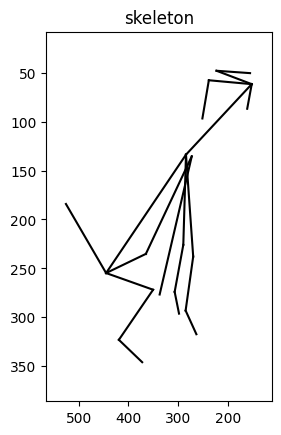

In [11]:
import matplotlib.pyplot as plt 

def plot_line(a, b):
    # print(a,b)
    # 관절마다 선긋기
    # if (a.any()> 0 and b.any()>0): 
    plt.plot([a["x"], b["x"]], [a["y"], b["y"]], 'k-')
    
def draw_skeleton(sample):
    
    skeleton = sample
    
    # 각 신체부위의 xy좌표 추출
    Left_Front_Paw = skeleton["Left_Front_Paw"]
    Left_Front_Wrist = skeleton["Left_Front_Wrist"]
    Left_Front_Elbow = skeleton["Left_Front_Elbow"]    
    
    Left_Back_Paw = skeleton["Left_Back_Paw"]
    Left_Back_Wrist = skeleton["Left_Back_Wrist"]
    Left_Back_Elbow = skeleton["Left_Back_Elbow"]

    Right_Front_Paw = skeleton["Right_Front_Paw"]
    Right_Front_Wrist = skeleton["Right_Front_Wrist"]
    Right_Front_Elbow = skeleton["Right_Front_Elbow"]
    
    Right_Back_Paw = skeleton["Right_Back_Paw"]
    Right_Back_Wrist = skeleton["Right_Back_Wrist"]
    Right_Back_Elbow = skeleton["Right_Back_Elbow"]
    
    Tail_Set = skeleton["Tail_Set"]
    Tail_Tip = skeleton["Tail_Tip"]
    
    Left_Base_Ear = skeleton["Left_Base_Ear"]
    Right_Base_Ear = skeleton["Right_Base_Ear"]
    
    Nose = skeleton["Nose"]
    Chin = skeleton["Chin"]
    
    Left_Tip_Ear = skeleton["Left_Tip_Ear"]
    Right_Tip_Ear = skeleton["Right_Tip_Ear"]
    
    Withers = skeleton["Withers"]

    
    inbox={'facecolor':'w','edgecolor':'r','boxstyle':'round','alpha':0.5}
    outbox={'facecolor':'w','edgecolor':'b','boxstyle':'round','alpha':0.5}
    # 각 관절 점 및 텍스트 표시
    for part in sample.values():
        plt.plot(part["x"], part["y"])
        # plt.text(part["x"], part["y"], '.', verticalalignment='bottom' , horizontalalignment='center' )
    
    # 신체에 맞게 각 관절 선으로 연결
    for part in link_parts:
        plot_line(sample[part[0]], sample[part[1]])
    
def skeleton_plot(sample):
    # 그래프 padding 값
    pad_ori = 40
    plt.subplot(122)
    plt.title('skeleton')
    X_ori = sample
    # print(X_ori)
    
    # 관절의 최대 최소값을 구해 그래프 영역 설정
    # print(X_ori)
    x = []
    y = []
    for v in X_ori.values():
        # print(v["x"])
        x.append(v["x"])
        y.append(v["y"])
    
    x_max = max(x) + pad_ori
    x_min = min(x) - pad_ori
    y_max = max(y) + pad_ori
    y_min = min(y) - pad_ori

    plt.xlim(x_max, x_min)
    plt.ylim(y_max, y_min)
    draw_skeleton(X_ori)
    
pose_list = json.load(open(f"{video_path}.json","r"))
# print(pose_list)
for img, pose in pose_list.items():
    if img == f"{1}_img":
        # print(pose)
        skeleton_plot(pose)

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn import model_selection

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree

def make_model(mod = "forest"):

    if mod == "svc":
        model = svm.SVC()
    elif mod == "tree":
        model = tree.DecisionTreeClassifier()
    elif mod == "forest":
        model = RandomForestClassifier()
    elif mod == "sgd":
        model = SGDClassifier()
    elif mod == "logistic":
        model = LogisticRegression()

    # print(model)

    return model

make_model()

RandomForestClassifier()

In [7]:
import json

def do_train():
    # data = get_data()
    data = np.load("angle.npy")
    
    x_train, x_test = model_selection.train_test_split(data, test_size=0.2)
    
    model = make_model()
    print(model)
    
    
    print(x_train.shape, x_test.shape)
    
do_train()

RandomForestClassifier()
(31, 5, 2) (8, 5, 2)
